## XGBoost를 이용한 위스콘신 유방암 예측
- 파이썬 Wrapper XGBoost를 사용

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label

In [ ]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=132)
X_train.shape, X_test.shape

((455, 30), (114, 30))

#### 학습과 예측 데이터 세트를 DMatrix로 변환

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#### 하이퍼 파라미터 설정

In [ ]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective':'binary:logistic', # default
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400

#### 주어진 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달하고 학습

In [ ]:
# train 데이터 셋은 'train', evaluation(test) 데이터 셋은 'eval'로 명시
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.609939	eval-logloss:0.616225
[1]	train-logloss:0.541506	eval-logloss:0.554254
[2]	train-logloss:0.48591	eval-logloss:0.500788
[3]	train-logloss:0.437417	eval-logloss:0.456181
[4]	train-logloss:0.395277	eval-logloss:0.417782
[5]	train-logloss:0.358608	eval-logloss:0.384178
[6]	train-logloss:0.327716	eval-logloss:0.355279
[7]	train-logloss:0.297865	eval-logloss:0.327795
[8]	train-logloss:0.271829	eval-logloss:0.303932
[9]	train-logloss:0.248807	eval-logloss:0.282771
[10]	train-logloss:0.228348	eval-logloss:0.265532
[11]	train-logloss:0.210183	eval-logloss:0.249486
[12]	train-logloss:0.194609	eval-logloss:0.236116
[13]	train-logloss:0.180073	eval-logloss:0.223901
[14]	train-logloss:0.167496	eval-logloss:0.214034
[15]	train-logloss:0.154758	eval-logloss:0.203845
[16]	train-logloss:0.145146	eval-logloss:0.19446
[17]	train-logloss:0.134994	eval-logloss:0.186289
[18]	train-logloss:0.125749	eval-logloss:0.178134
[19]	train-logloss:0.11781	eval-logloss:0.172371
[20]	train-lo

#### predict()를 통해 확률값을 반환하고 예측 값으로 변환
- 파이썬 Wrapper는 predict시 확률값을 반환한다

In [ ]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print(preds[:10])

[0.777 0.006 0.966 0.001 1.    0.002 0.997 0.998 1.    1.   ]
[1, 0, 1, 0, 1, 0, 1, 1, 1, 1]


#### get_clf_eval()을 통해 예측 평가

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 평가지표
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred) # 정밀도
  recall = recall_score(y_test, pred) # 재현율
  f1 = f1_score(y_test, pred) # 정밀도와 재현율을 결합한 지표 (두 지표가 어느 한쪽으로 치우치지 않을 때 높은 값을 가짐)
  roc_auc = roc_auc_score(y_test, pred_proba) # FPR이 변할 때 TPR(재현율)이 어떻게 변하는지를 나타내는 곡선 (1에 가까울수록 높은 수치)

  print('오차행렬')
  print(confusion)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[48  2]
 [ 1 63]]
정확도: 0.9737, 정밀도: 0.9692, 재현율: 0.9844, F1: 0.9767, AUC: 0.9950


#### Feature Importance 시각화

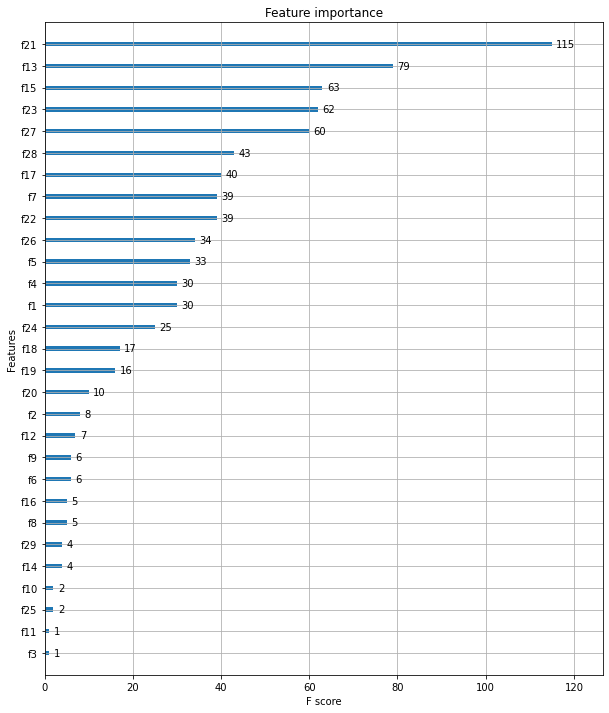

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## 사이킷런 Wrapper XGBoost 적용

In [ ]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400, eval_set=evals, eval_metric='logloss', verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.616225
Will train until validation_0-logloss hasn't improved in 400 rounds.
[1]	validation_0-logloss:0.554254
[2]	validation_0-logloss:0.500788
[3]	validation_0-logloss:0.456181
[4]	validation_0-logloss:0.417782
[5]	validation_0-logloss:0.384178
[6]	validation_0-logloss:0.355279
[7]	validation_0-logloss:0.327795
[8]	validation_0-logloss:0.303932
[9]	validation_0-logloss:0.282772
[10]	validation_0-logloss:0.265532
[11]	validation_0-logloss:0.249486
[12]	validation_0-logloss:0.236116
[13]	validation_0-logloss:0.223901
[14]	validation_0-logloss:0.214034
[15]	validation_0-logloss:0.203845
[16]	validation_0-logloss:0.19446
[17]	validation_0-logloss:0.186289
[18]	validation_0-logloss:0.178134
[19]	validation_0-logloss:0.172371
[20]	validation_0-logloss:0.1661
[21]	validation_0-logloss:0.159891
[22]	validation_0-logloss:0.155131
[23]	validation_0-logloss:0.15143
[24]	validation_0-logloss:0.147044
[25]	validation_0-logloss:0.143981
[26]	validation_0-logloss:0.14071
[

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[48  2]
 [ 1 63]]
정확도: 0.9737, 정밀도: 0.9692, 재현율: 0.9844, F1: 0.9767, AUC: 0.9956


In [ ]:
#### ealy stopping을 100으로 설정하고 재학습/예측/평가
from xgboost import XGBClassifier

evals = [(X_test, y_test)]

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals, eval_metric='logloss', verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.616225
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.554254
[2]	validation_0-logloss:0.500788
[3]	validation_0-logloss:0.456181
[4]	validation_0-logloss:0.417782
[5]	validation_0-logloss:0.384178
[6]	validation_0-logloss:0.355279
[7]	validation_0-logloss:0.327795
[8]	validation_0-logloss:0.303932
[9]	validation_0-logloss:0.282772
[10]	validation_0-logloss:0.265532
[11]	validation_0-logloss:0.249486
[12]	validation_0-logloss:0.236116
[13]	validation_0-logloss:0.223901
[14]	validation_0-logloss:0.214034
[15]	validation_0-logloss:0.203845
[16]	validation_0-logloss:0.19446
[17]	validation_0-logloss:0.186289
[18]	validation_0-logloss:0.178134
[19]	validation_0-logloss:0.172371
[20]	validation_0-logloss:0.1661
[21]	validation_0-logloss:0.159891
[22]	validation_0-logloss:0.155131
[23]	validation_0-logloss:0.15143
[24]	validation_0-logloss:0.147044
[25]	validation_0-logloss:0.143981
[26]	validation_0-logloss:0.14071
[

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[48  2]
 [ 1 63]]
정확도: 0.9737, 정밀도: 0.9692, 재현율: 0.9844, F1: 0.9767, AUC: 0.9956
